# AirBNB homes in Seattle and Boston.

In this notebook, I will answer three questions below:

1. What is the important element for hosts/rooms to be booked maltiple times?
2. Waht is the price range of hosts/rooms booked maltiple times?
3. What are the hosts/rooms' features with higher review score?

In [1]:
# import libralies here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler as sc

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
# read csv files that wil be used for nswering questions

seattle  = pd.read_csv('seattle_listtings.csv')
boston = pd.read_csv('boston_listings.csv')

Source of the data sets ^: http://insideairbnb.com/get-the-data.html

In [4]:
# checking the length of each data frame in case
print(len(seattle))
print(len(boston))

7017
3440


## 1. Data cleaning
- Combine dataframes of house in Seattle and on Boston in 2020.
- Making data frame of hosts who offered their place over 2 times in 2020 to answer question 1 and 2.

In [5]:
# checking if the dataframs have the same columns
seattle.columns == boston.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [6]:
# Combining the data frames
master_df = pd.concat([seattle, boston])
# Changing the name of id to listing_id
master_df.rename(columns={'id':'listing_id'}, inplace = True)
#Checking the lenght in case.
master_df.shape[0]

10457

In [7]:
# make a function 

def host_multiple(number): 
    
    """
    Description: This function can be used to make a data frame of the hosts/rooms which are booked multiple times. 
    You can set the times by changing the arguments. (e.g. 2 => booked over 2 times. 5 => booked over 5 times)

    Arguments:
    number: Over how many times the hosts/rooms are booked. 
    
    Returns:
    popular_host (data frame)
    """

    popular_host = master_df.groupby('host_id').count()
    popular_host = popular_host.loc[popular_host["listing_id"] >= number]
    popular_host.rename(columns = {"listing_id":"Count"}, inplace = True)
    popular_host = popular_host[["Count", "listing_url"]]
    popular_host = popular_host.merge(master_df, how= "left", on = "host_id")
    popular_host.drop(['listing_url_x'], axis=1, inplace = True)

    return popular_host

In [8]:
#Making data set of host who offered their room multiple times (over 2)
popular_host = host_multiple(2)

In [9]:
popular_host_clusterning = popular_host[['host_id','review_scores_rating', 'host_response_rate', 'price']].set_index('host_id')
popular_host_clusterning['host_response_rate'] = popular_host_clusterning['host_response_rate'].str.replace('%', '').astype('float')
popular_host_clusterning['price'] = popular_host_clusterning['price'].str.replace('$', '')
popular_host_clusterning['price'] = popular_host_clusterning['price'].str.replace(',', '').astype('float')
popular_host_clusterning.shape

(6187, 3)

In [10]:
popular_host_clusterning.isna().sum()

review_scores_rating    1232
host_response_rate       608
price                      0
dtype: int64

In [11]:
popular_host_clusterning.review_scores_rating.mean()

93.42078708375378

For clustering, I will simply drop missing values.  

I will find the features of hosts/rooms booked multiple times. In this case, replacing missing values in "review_scores_rating" and "host_response_rate" would be lead to incorrect rrsults.   

For example, the mean value of "review_scores_rating" about 94. If I replace all missing values with the mean, it means more hosts get higher quite high review score and I cannnot say it reflects actual review scores.   
Also, I will still have 4955 values after dropping. It is enough number to find the features.  

Hence, I will drop missing values.

In [12]:
popular_host_clusterning.dropna(inplace = True)

In [13]:
popular_host_clusterning.isna().sum()

review_scores_rating    0
host_response_rate      0
price                   0
dtype: int64

## 2. Data Analysis

### 2.1. Analyzing features of hosts who offered their place over two times by using clusterinig

In this section, I will use clustering to find the features of hosts who offered their room to guests over 2 times to answer the question 1 and 2.

The elements of this analysis are: 
1. review_scores_rating
2. host_response_rate
3. price

In [14]:
popular_host_clusterning.columns

Index(['review_scores_rating', 'host_response_rate', 'price'], dtype='object')

In [15]:
popular_host_clusterning = popular_host_clusterning.groupby('host_id').agg(
    {'review_scores_rating': 'mean',
     'host_response_rate': 'mean',
     'price': 'mean'
    })

In [16]:
popular_host_clusterning.dtypes

review_scores_rating    float64
host_response_rate      float64
price                   float64
dtype: object

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
popular_host_clusterning_sc = sc.fit_transform(popular_host_clusterning)

In [18]:
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit(popular_host_clusterning_sc)
popular_host_clusterning["cluster"] = clusters.labels_
print(popular_host_clusterning["cluster"].unique())
popular_host_clusterning.head()

[5 4 0 1 3 2]


,review_scores_rating,host_response_rate,price,cluster
host_id,,,,
2536,96.500000,67.0,200.500000,5
4193,95.666667,100.0,35.000000,4
7969,89.500000,83.0,25.500000,0
8229,95.000000,100.0,187.666667,4
14942,93.000000,100.0,169.666667,0


In [19]:
len(popular_host_clusterning)

972

In [46]:
count = popular_host_clusterning.groupby("cluster").count()
count.rename(columns = {"review_scores_rating":"count","host_response_rate": "count3","price":"count3"}, inplace = True)
mean = popular_host_clusterning.groupby("cluster").mean()
clustering_table = mean.merge(count, how = 'left', on = 'cluster')
clustering_table = clustering_table.iloc[:,:4]

In [47]:
clustering_table

,review_scores_rating,host_response_rate,price,count
cluster,,,,
0,90.193588,98.115063,123.672207,199
1,91.121795,20.625000,188.901442,16
2,85.500000,97.000000,10000.000000,1
3,73.753756,91.400000,225.595855,25
4,97.427703,99.323398,150.147864,671
5,95.348731,72.183333,151.465393,60


### FInding 2.1.

We can devide the popular hosts into 6 groups:

0. high review score (90), high response rate (98), average price 123 - Total(199)
1. high review score (91), very low response rate (21), average price 188 - Total(16)
2. Exceptioanl case, very high price 10000 - Only 1
3. low review score (73), high response rate (91), average price 226 - Total(25)
4. highest review score (98), highest response rate (99), average price 150 - Total(671)
5. high review score (95), low response rate (72), average price 152 - Total(60)

Group 4 is the most poupar group in all, and its features are "highest review score (98), highest response rate (99), average price 150"
The second biggest destribution of them is occupied by group 0 with the features of high review score (90), high response rate (98), average price 123. 

In [22]:
print(np.percentile(popular_host_clusterning['price'], 75))
print(np.percentile(popular_host_clusterning['price'], 90))

171.5
253.2933333333333


Text(0.5, 0, 'Price')

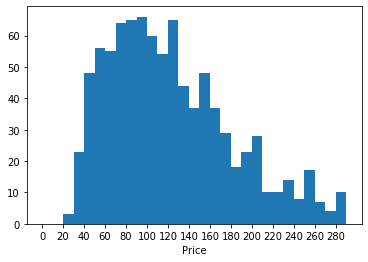

In [23]:
plt.hist(data=popular_host_clusterning, x='price', bins=np.arange(0, 300, 10))
plt.xticks(np.arange(0, 300, 20))
plt.xlabel('Price')

In [24]:
# pecentage of rooms with the cost $40 to 170
price_40_170 = popular_host_clusterning[(popular_host_clusterning['price'] > 40)&(popular_host_clusterning['price'] < 170)] 
len(popular_host_clusterning)
len(price_40_170)/len(popular_host_clusterning)

0.7170781893004116

As the hist graph shows, 75% of average price is lower than $172.<br>
Also, 72% of room price is between ＄40 and ＄170. 

### 2.2. Analyze the status of cancelation policy of high rated place.
Next, I will analyze the elements causing higher review scores.

In [25]:
# Make a dataframe of places whose review_scores_rating is over  95
high = master_df[master_df['review_scores_rating'] >= 95]

In [26]:
high.cancellation_policy.unique()

array(['strict_14_with_grace_period', 'moderate', 'flexible',
       'super_strict_60', 'super_strict_30', 'strict'], dtype=object)

Strict cacellation policy is devided into three categories.
To make them simple, I will make one group for them.

In [27]:
for st in ['strict_14_with_grace_period','super_strict_60', 'super_strict_30']:
    high['cancellation_policy'] = high['cancellation_policy'].str.replace(st, 'strict')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-1.1207771737602314,
 1.1206705015781901,
 -1.11441980706056,
 1.1270278682778616)

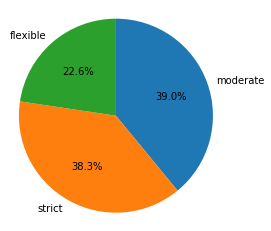

In [28]:
percentage = high.cancellation_policy.value_counts()/high.shape[0]
plt.pie(percentage, labels=percentage.index, startangle=90, counterclock=False, autopct='%1.1f%%')
plt.axis('square')

### Finding 2.2.
In the places with higher rate, the cancelation policy tends to be modern or strict. <br>
There are three main components: "strict_14_with_grace_period", "moderate" and  "flexible." <br>
The percentage of flexible policy is lower (22%) than other two (over 38%) 

### 2.3 Analyze the importance of host_response_rate for getting higher rate

In [29]:
high_response = high.dropna(subset = ['host_response_rate'])

high_response['host_response_rate_flag'] = 0
high_response['host_response_rate'] = high_response['host_response_rate'].str.replace('%', '').astype('int')

high_response['host_response_rate_flag'] = high_response['host_response_rate_flag'].where(high_response['host_response_rate'] < 90, 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [30]:
high_response['host_response_rate_flag']

0       0
3       1
4       1
6       1
7       1
       ..
3313    1
3323    1
3372    1
3409    1
3412    1
Name: host_response_rate_flag, Length: 4613, dtype: int64

In [31]:
high_response['host_response_rate_flag'].sum()/len(high_response)

0.9308476045957078

### Finding 2.3.
About 90% of hosts with higher review scores has over 90% of response rate. 

## 2.4. Analyze the popular room type
Finally, I will analyze what is popular room type. 

In [32]:
high.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [33]:
# relationshio between cancelation policy and rating
rooms = list(high.room_type.unique())
dist_of_cancelation = []
total = len(high)
x = 0

for room in rooms:
    length = len(high[high['room_type'] == room])
    dist_of_cancelation.append(length)
    print("{0}: ".format(rooms[x]) + str(dist_of_cancelation[x]/total))
    x += 1

Entire home/apt: 0.732313260941099
Private room: 0.2548535702533728
Shared room: 0.007568279039157618
Hotel room: 0.0052648897663705166


(-1.1100033857740386,
 1.1191237291954328,
 -1.1163671281203624,
 1.112759986849109)

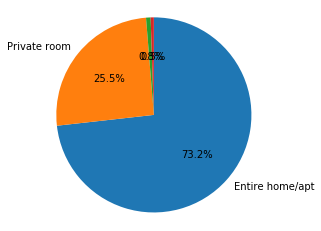

In [35]:
percentage = high.room_type.value_counts()/high.shape[0]
percentage.rename(index = {"Shared room":"", "Hotel room": ""}, inplace = True)
plt.pie(percentage, labels=percentage.index, startangle=90, counterclock=False, autopct='%1.1f%%')
plt.axis('square')

### 2.4. Finding 
The raph shows that 73% of room with high review score type is Entire home/apt and 25% is Private room.

## Answering Question

### 1. What are the important elements for hosts/rooms to be booked maltiple times?
Answer - Judging from the result of clustering, review score and response rate are the important elements and they should be high (over 90%)

### 2. What is the price range of hosts/rooms booked maltiple times?
Answer - The average price of 75% of hosts/rooms is less than ＄170.  
Also, 72% of room price is between ＄40 and ＄170. 

### 3. What are the features of hosts/rooms with higher review score? 
Answer - It can be seen that the hosts/rooms with higher review scores have high response rate (93%).<br>
Additionally, 73% of roomtypes of them is  Entire home/apt and 26% is private room. Shared room and hotel room are not usual for room types with high review score.


